<a href="https://colab.research.google.com/github/dimitri009/Optimization-Project-work/blob/main/Optimization_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Work in Optimization Methods/Optimization Techniques for Machine Learning**

# Assignment

*   **Project topic :** Evaluating the performance of Gradient Descent and Newton’s methods
on Logistic Regression Problems

*   **Topic description :** Logistic regression models are trained solving a nonlinear optimization problem (see Lecture notes, Sec. 2.3). This problem can be solved using any
of the most popular solvers for nonlinear unconstrained optimization. In particular,
gradient descent method and Newton’s method are both viable options.

*   **Topic description :**
    1.   Implement (in Python language, exploit numpy library) classes and functions
allowing to load data to build an instance of ℓ2-regularized logistic regression
problem, compute the loss, the gradient of the loss and the Hessian (see Lecture
notes, Sec. 2.3).

    2.    Implement gradient descent and Newton’s method. Gradient descent should be
equipped with an Armijo-type line search.

    3.   entify a small set of real-world instances (∼ 6 datasets), to carry out experiments.
    4.    Test the efficiency of the considered methods on this benchmark of problems,
measuring the number of iterations and the runtime needed to reach solutions
that are (approximately) stationary points. Also report the objective value at
the obtained final solutions.

    5.    **Bonus task:** Include in the comparison the conjugate gradient method that
can be found in the scipy.optimize module.


In [18]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import time

In [33]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class LogisticRegressionL2:
    def __init__(self, reg_param=1.0):
        self.reg_param = reg_param
        self.theta = None

    def compute_loss(self, X, y, theta, reg_param):
        m = len(y)
        z = X.dot(theta)
        h = sigmoid(z)
        epsilon = 1e-15
        loss = (-y * np.log(h + epsilon) - (1 - y) * np.log(1 - h + epsilon)).mean() + (reg_param / (2 * m)) * np.sum(theta ** 2)
        return loss

    def compute_gradient(self, X, y, theta, reg_param):
        m = len(y)
        z = X.dot(theta)
        h = sigmoid(z)
        gradient = (1 / m) * (X.T.dot(h - y) + reg_param * theta)
        return gradient

    def gradient_descent(self, X, y, max_iter=10000, learning_rate=0.1, tol=1e-3):
        m, n = X.shape
        y = y.reshape(-1, 1)
        self.theta = np.zeros((n, 1))  # Initialize weights
        i = 0
        diff = 1

        cost_values = []
        gamma = 0.7

        start_time = time.time()

        while i < max_iter and diff > tol:
            alpha = learning_rate
            z = X.dot(self.theta)
            h = sigmoid(z)

            gradient = (1 / m) * (X.T.dot(h - y) + self.reg_param * self.theta)

            # Armijo-type line search
            while True:
                new_theta = self.theta - alpha * gradient

                loss_new = self.compute_loss(X, y, new_theta, self.reg_param)
                loss_current = self.compute_loss(X, y, self.theta, self.reg_param)
                diff = np.abs(loss_current - loss_new)


                linear_approximation = gamma * alpha * np.squeeze(gradient).dot(np.squeeze(gradient))

                # print('liner_approximation: ', round(linear_approximation, 3), 'loss_new:', round(loss_new, 3),
                #       'current_loss', round(loss_current, 3), 'loss_current - linear_approximation', round(loss_current - linear_approximation, 3))
                if loss_new <= loss_current - linear_approximation:
                    break
                alpha *= 0.5
                print(alpha)
                break


            self.theta = new_theta.copy()
            cost_values.append(loss_current)

            # if (i % (max_iter / 10) == 0) or alpha != learning_rate:
            #     print("Cost after", i, "iterations is:", loss_current, "Learning rate:", alpha)
            i += 1

        end_time = time.time()
        runtime = end_time - start_time

        # print('\nGradient descent')
        # print("Total iterations:", i)
        # print("Runtime:", runtime, "seconds")
        return self.theta, cost_values, runtime, i

    def newtons_method(self, X, y, max_iter=1000, tol=1e-3):
        m, n = X.shape
        y = y.reshape(-1, 1)
        self.theta = np.zeros((n, 1))  # Initialize weights
        cost_values = []
        diff = 1
        iter_count = 0

        start_time = time.time()

        while iter_count < max_iter and diff > tol:
            z = X.dot(self.theta)
            h = sigmoid(z)

            gradient = (1 / m) * X.T.dot(h - y)
            hessian = np.linalg.inv(X.T.dot(np.diagflat(h)).dot(X) + self.reg_param * np.identity(n))

            # Solve for the update using the Newton's method equation
            update = hessian.dot(gradient)
            self.theta -= update

            cost_values.append(self.compute_loss(X, y, self.theta, self.reg_param))
            iter_count = iter_count + 1
            # Check for convergence
            if np.linalg.norm(update) < tol:
                break


            if iter_count > 1:
              diff = np.abs(cost_values[-1] - cost_values[-2])



        end_time = time.time()
        runtime = end_time - start_time

        # print('\nNewtons method')
        # print("Total iterations:", iter_count)
        # print("Runtime:", runtime, "seconds")
        return self.theta, cost_values, runtime, iter_count

    def gradient_conjugate(self, X, y):
        # Implement gradient conjugate using scipy.optimize.minimize
        m, n = X.shape
        y = y.reshape(-1, 1)
        self.theta = np.zeros((n, 1))  # Initialize weights
        loss = lambda theta: self.compute_loss(X, y, theta.reshape(-1, 1), self.reg_param)
        gradient = lambda theta: self.compute_gradient(X, y, theta.reshape(-1, 1), self.reg_param).flatten()

        start_time = time.time()
        result = minimize(fun=loss, x0=self.theta.flatten(), jac=gradient, method='CG', options={'maxiter': 100, 'disp': False})
        end_time = time.time()

        self.theta = result.x.reshape(-1, 1)
        runtime = end_time - start_time

        # print('\nConjugate gradient')
        # print("Runtime:", runtime, "seconds")
        return self.theta, runtime, result

    def test(self, X_test, y_test):
        h = sigmoid(X_test.dot(self.theta))
        y_pred = np.where(h > 0.5, 1, 0)
        y_test = y_test.reshape(-1, 1)
        accuracy = np.mean(y_pred == y_test)
        # print("Accuracy:", accuracy)
        return accuracy


In [34]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [35]:
def fit_logistic_regression_methods(X_train, y_train, reg_param=1.0):
    logistic_reg = LogisticRegressionL2(reg_param)

    # Gradient Descent
    theta_gd, cost_values_gd, runtime_gd, iterations_gd = logistic_reg.gradient_descent(X_train, y_train)
    accuracy = logistic_reg.test(X_val,y_val)
    result_gd = {
        'last_cost_value': cost_values_gd[-1],
        'runtime': runtime_gd,
        'iterations': iterations_gd,
        'accuracy': accuracy
    }

    # Newton's Method
    theta_newton, cost_values_newton, runtime_newton, iterations_newton = logistic_reg.newtons_method(X_train, y_train)
    accuracy = logistic_reg.test(X_val,y_val)
    result_newton = {
        'last_cost_value': cost_values_newton[-1],
        'runtime': runtime_newton,
        'iterations': iterations_newton,
        'accuracy': accuracy
    }

    # Gradient Conjugate
    theta_conjugate, runtime_conjugate, result = logistic_reg.gradient_conjugate(X_train, y_train)
    accuracy = logistic_reg.test(X_val,y_val)
    last_cost_value = result.fun
    num_iterations = result.nit
    result_conjugate = {
        'last_cost_value': last_cost_value,
        'runtime': runtime_conjugate,
        'iterations': num_iterations,
        'accuracy': accuracy
    }

    results = {
        'Gradient Descent': result_gd,
        'Newton\'s Method': result_newton,
        'Gradient Conjugate': result_conjugate
    }

    return results



In [36]:
def test_logistic_regression_methods(X_train, y_train, X_test, y_test, reg_param=1.0):
    logistic_reg = LogisticRegressionL2(reg_param)

    # Gradient Descent

    theta_gd, cost_values_gd, elapsed_time_gd, _ = logistic_reg.gradient_descent(X_train, y_train)
    accuracy_gd = logistic_reg.test(X_test, y_test)

    plt.plot(range(1, len(cost_values_gd) + 1), cost_values_gd, label='Gradient Descent')

    # Newton's Method
    theta_newton, cost_values_newton, elapsed_time_newton, _ = logistic_reg.newtons_method(X_train, y_train)
    accuracy_newton = logistic_reg.test(X_test, y_test)

    plt.plot(range(1, len(cost_values_newton) + 1), cost_values_newton, label='Newton\'s Method')

    # Test and print accuracies
    print(f"Gradient Descent Accuracy: {accuracy_gd:.4f} (Time: {elapsed_time_gd:.4f} seconds)")
    print(f"Newton's Method Accuracy: {accuracy_newton:.4f} (Time: {elapsed_time_newton:.4f} seconds)")

    plt.title('Cost Function over Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.legend()
    plt.show()

In [37]:
def plot_logistic_regression_results(results):
    methods = list(results.keys())

    # Plotting Accuracy
    accuracies = [results[method]['accuracy'] for method in methods]
    plt.figure(figsize=(10, 5))
    plt.bar(methods, accuracies, color=['blue', 'orange', 'green'])
    plt.title('Accuracy of Logistic Regression Methods')
    plt.ylabel('Accuracy')
    plt.show()

    # Plotting Runtime
    iterations = [results[method]['runtime'] for method in methods]
    plt.figure(figsize=(10, 5))
    plt.bar(methods, iterations, color=['blue', 'orange', 'green'])
    plt.title('Runtime of Logistic Regression Methods')
    plt.ylabel('Runtime')
    plt.show()

# Breast cancer dataset

The breast cancer dataset is a classic binary classification dataset.

Ten real-valued features are computed for each cell nucleus:

	a) radius (mean of distances from center to points on the perimeter)
	b) texture (standard deviation of gray-scale values)
	c) perimeter
	d) area
	e) smoothness (local variation in radius lengths)
	f) compactness (perimeter^2 / area - 1.0)
	g) concavity (severity of concave portions of the contour)
	h) concave points (number of concave portions of the contour)
	i) symmetry
	j) fractal dimension ("coastline approximation" - 1)

* Classes: 2

* Samples per class: 212(M),357(B)

* Samples total: 569

* Dimensionality: 30

* Features: real, positive

Additional informations:

* Instances: 569

* Features: 30

In [38]:
# Load the Breast Cancer Wisconsin dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Standardize the feature matrix
scaler = StandardScaler()
X = scaler.fit_transform(X)


# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:

results_dict = fit_logistic_regression_methods(X_train, y_train, reg_param=1.0)

# Print the results
for method, result in results_dict.items():
    print(f"\nResults for {method}:\n", result)



Results for Gradient Descent:
 {'last_cost_value': 0.14190946075756944, 'runtime': 0.018695592880249023, 'iterations': 49, 'accuracy': 0.9736842105263158}

Results for Newton's Method:
 {'last_cost_value': 0.6915551170019546, 'runtime': 0.0026400089263916016, 'iterations': 2, 'accuracy': 0.9473684210526315}

Results for Gradient Conjugate:
 {'last_cost_value': 0.07011962250217085, 'runtime': 0.015914440155029297, 'iterations': 30, 'accuracy': 0.9824561403508771}


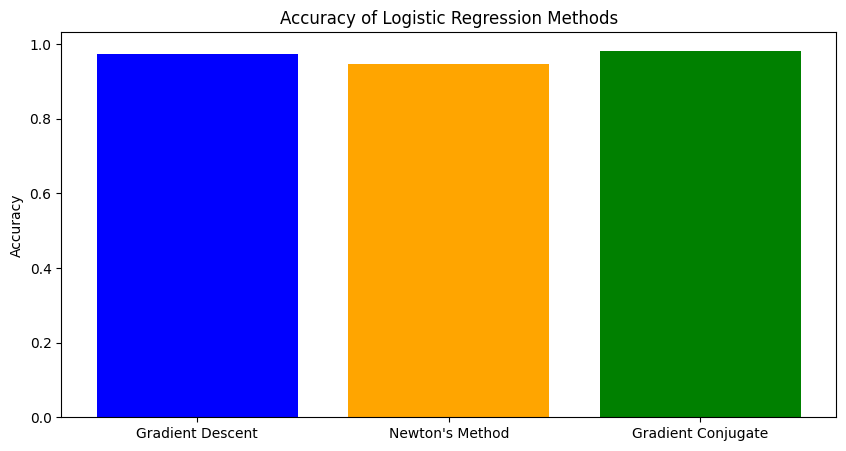

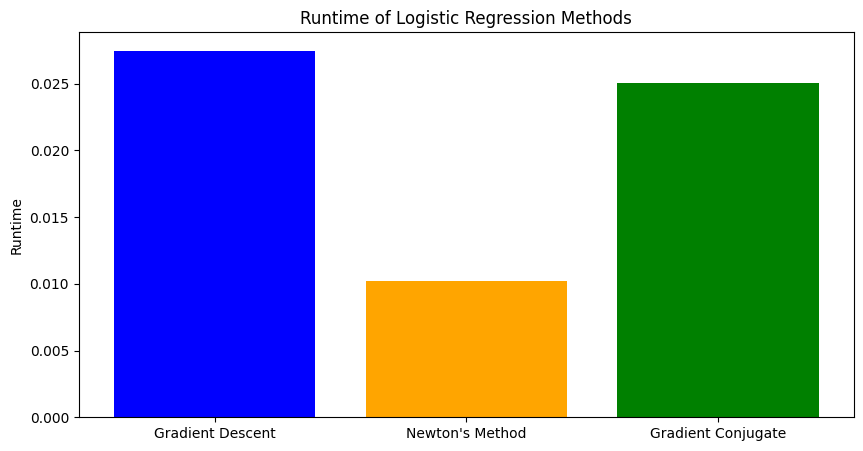

In [9]:
plot_logistic_regression_results(results_dict)

**Findings:**

* Accuracy: Gradient Conjugate achieved the highest accuracy (98.25%) on the
breast cancer dataset, followed closely by Gradient Descent (97.37%). Newton's Method achieved a slightly lower accuracy (94.74%).

* Runtime: Newton's Method had the fastest runtime (0.0026 seconds), indicating that it converged quickly. Gradient Descent and Gradient Conjugate had similar runtimes, with Gradient Conjugate being slightly longer.

* Iterations: Newton's Method required only 2 iterations to converge, which is significantly lower than Gradient Descent (49 iterations) and Gradient Conjugate (30 iterations). This suggests that Newton's Method reached a stationary point more rapidly.

**Conclusion:**

For this specific breast cancer dataset, Gradient Conjugate appears to be the most efficient in terms of both accuracy and convergence speed.
Newton's Method is efficient in terms of convergence speed but achieved a slightly lower accuracy compared to Gradient Conjugate.
Gradient Descent, while accurate, required more iterations and had a longer runtime compared to the other methods.
It's important to note that the effectiveness of each optimization method can vary based on the dataset and problem characteristics. The choice of method may depend on the trade-off between accuracy, convergence speed, and computational resources.

In [40]:
pip install ucimlrepo

# Ionosphere Dataset
Classification of radar returns from the ionosphere
Dataset Information
Additional Information

This radar data was collected by a system in Goose Bay, Labrador.  This system consists of a phased array of 16 high-frequency antennas with a total transmitted power on the order of 6.4 kilowatts.  See the paper for more details.  The targets were free electrons in the ionosphere. "Good" radar returns are those showing evidence of some type of structure in the ionosphere.  "Bad" returns are those that do not; their signals pass through the ionosphere.  

Received signals were processed using an autocorrelation function whose arguments are the time of a pulse and the pulse number.  There were 17 pulse numbers for the Goose Bay system.  Instances in this databse are described by 2 attributes per pulse number, corresponding to the complex values returned by the function resulting from the complex electromagnetic signal.


*  Instances 351
*   Features 34 (All 34 are continuous)
* The 35th attribute is either "good" or "bad" according to the definition summarized above.  This is a binary classification task.


# Missing Values: NO

In [41]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
ionosphere = fetch_ucirepo(id=52)

# data (as pandas dataframes)
X = ionosphere.data.features
y = ionosphere.data.targets

# metadata
print(ionosphere.metadata)

# variable information
print(ionosphere.variables)

{'uci_id': 52, 'name': 'Ionosphere', 'repository_url': 'https://archive.ics.uci.edu/dataset/52/ionosphere', 'data_url': 'https://archive.ics.uci.edu/static/public/52/data.csv', 'abstract': 'Classification of radar returns from the ionosphere', 'area': 'Physics and Chemistry', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 351, 'num_features': 34, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1989, 'last_updated': 'Sun Jan 01 1989', 'dataset_doi': '10.24432/C5W01B', 'creators': ['V. Sigillito', 'S. Wing', 'L. Hutton', 'K. Baker'], 'intro_paper': None, 'additional_info': {'summary': 'This radar data was collected by a system in Goose Bay, Labrador.  This system consists of a phased array of 16 high-frequency antennas with a total transmitted power on the order of 6.4 kilowatts.  See the paper for more details.  

In [42]:
y = np.where(y['Class'] == 'g', 1, 0)
print(y)


[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [43]:
print(X.shape)
X = X.values

(351, 34)


In [44]:
X = scaler.fit_transform(X)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
results_dict = fit_logistic_regression_methods(X_train, y_train, reg_param=1.0)

# Print the results
for method, result in results_dict.items():
    print(f"\nResults for {method}:\n", result)


Results for Gradient Descent:
 {'last_cost_value': 0.3230572544541579, 'runtime': 0.048552751541137695, 'iterations': 70, 'accuracy': 0.8873239436619719}

Results for Newton's Method:
 {'last_cost_value': 0.6850937395624074, 'runtime': 0.012019157409667969, 'iterations': 8, 'accuracy': 0.8873239436619719}

Results for Gradient Conjugate:
 {'last_cost_value': 0.20173359429413568, 'runtime': 0.1407766342163086, 'iterations': 48, 'accuracy': 0.8732394366197183}


**Findings:**

* Accuracy: Gradient Descent and Newton's Method achieved the highest accuracy of 88.73%, while Gradient Conjugate had a slightly lower accuracy of 87.32%.

* Runtime: Newton's Method had the fastest runtime (0.0120 seconds), followed by Gradient Descent (0.0486 seconds) and Gradient Conjugate (0.1408 seconds). Newton's Method was significantly faster.

* Iterations: Gradient Descent required the highest number of iterations (70), followed by Gradient Conjugate (48) and Newton's Method (8).


**Conclusion:**

Newton's Method stands out in terms of both accuracy and convergence speed for the Ionosphere dataset, with the fewest iterations and the fastest runtime.
Gradient Descent also performed well in terms of accuracy but required more iterations compared to Newton's Method.
Gradient Conjugate, while accurate, had a slightly lower accuracy and required more iterations than Newton's Method.
As always, the choice of optimization method depends on the specific characteristics of the dataset and the problem at hand.

# Diabetes Dataset
About Dataset
Context
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic measurements whether a patient has diabetes.

Content
Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

* Pregnancies: Number of times pregnant

*   Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
*   BloodPressure: Diastolic blood pressure (mm Hg)
*   SkinThickness: Triceps skin fold thickness (mm)
*   Insulin: 2-Hour serum insulin (mu U/ml)
*   BMI: Body mass index (weight in kg/(height in m)^2)
*   DiabetesPedigreeFunction: Diabetes pedigree function
*   Age: Age (years)
*   Outcome: Class variable (0 or 1)


# Missing Attribute Values: Yes

In [46]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [47]:
import pandas as pd

In [48]:
# Define the file path
file_path = '/content/drive/MyDrive/dataOP/diabetes.csv'

# Load the dataset into a DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [49]:
# Features (X)
X = df.drop(columns=['Outcome'])  # Exclude the 'Outcome' column

# Target variable (y)
y = df['Outcome']

# Display the first few rows of X and y
print("Features (X):")
print(X.head())

print("\nTarget variable (y):")
print(y.head())

Features (X):
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  
0                     0.627   50  
1                     0.351   31  
2                     0.672   32  
3                     0.167   21  
4                     2.288   33  

Target variable (y):
0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64


In [50]:
X = X.values
y = y.values

print(X.shape)
print(y.shape)

(768, 8)
(768,)


In [51]:
# Standardize the feature matrix
scaler = StandardScaler()
X = scaler.fit_transform(X)


# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
results_dict = fit_logistic_regression_methods(X_train, y_train, reg_param=1.0)

# Print the results
for method, result in results_dict.items():
    print(f"\nResults for {method}:\n", result)


Results for Gradient Descent:
 {'last_cost_value': 0.5599950360434437, 'runtime': 0.009913206100463867, 'iterations': 38, 'accuracy': 0.7012987012987013}

Results for Newton's Method:
 {'last_cost_value': 0.6929175564737095, 'runtime': 0.005495786666870117, 'iterations': 1, 'accuracy': 0.6883116883116883}

Results for Gradient Conjugate:
 {'last_cost_value': 0.5272842948782798, 'runtime': 0.006127595901489258, 'iterations': 12, 'accuracy': 0.6883116883116883}


**Findings:**

* Accuracy: Gradient Descent achieved the highest accuracy of 70.13%, while Newton's Method and Gradient Conjugate had a slightly lower accuracy of 68.83%.

* Runtime: Newton's Method had the fastest runtime (0.0055 seconds), followed by Gradient Conjugate (0.0061 seconds) and Gradient Descent (0.0099 seconds).

* Iterations: Newton's Method had the fewest iterations (1), Gradient Conjugate had 12 iterations, and Gradient Descent required 38 iterations.

**Conclusion:**

Gradient Descent achieved the highest accuracy on the Diabetes dataset but required more iterations compared to the other methods.
Newton's Method demonstrated fast convergence with the fewest iterations and the fastest runtime.
Gradient Conjugate, while accurate, had a slightly lower accuracy and required more iterations compared to Newton's Method.

# Wine Quality
Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests

Input variables (based on physicochemical tests):
   * fixed acidity
   * volatile acidity
   * citric acid
   * residual sugar
   * chlorides
   * free sulfur dioxide
   * total sulfur dioxide
   * density
   * pH
   * sulphates
   * alcohol

Output variable (based on sensory data):
   * quality (score between 0 and 10)

Additional informations:
* Instances: 4898

* Features: 11

In [59]:
# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets

# metadata
print(wine_quality.metadata)

# variable information
print(wine_quality.variables)

{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'title': 'Modeling wine preferences by data mining from physicoc

In [60]:
# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns

# Drop categorical columns from X
X_no_categorical = X.drop(columns=categorical_columns)

# Display the first few rows of the updated X
print("Features (X) after dropping categorical columns:")
print(X_no_categorical.head())

Features (X) after dropping categorical columns:
   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  
0      9.4  
1      9.8 

In [61]:
X = X.values
print(X)

[[ 7.4   0.7   0.   ...  3.51  0.56  9.4 ]
 [ 7.8   0.88  0.   ...  3.2   0.68  9.8 ]
 [ 7.8   0.76  0.04 ...  3.26  0.65  9.8 ]
 ...
 [ 6.5   0.24  0.19 ...  2.99  0.46  9.4 ]
 [ 5.5   0.29  0.3  ...  3.34  0.38 12.8 ]
 [ 6.    0.21  0.38 ...  3.26  0.32 11.8 ]]


In [62]:
print(y.head(20))

    quality
0         5
1         5
2         5
3         6
4         5
5         5
6         5
7         7
8         7
9         5
10        5
11        5
12        5
13        5
14        5
15        5
16        7
17        5
18        4
19        6


In [63]:
# Define the bin edges for the binary transformation
bin_edges = [0, 5, 10]

# Use numpy's digitize function to create the binary variable
y = np.digitize(y['quality'], bins=bin_edges, right=True) -1

# Display the transformed target variable
print("Transformed target variable (y_binary):")
print(y[:20])

Transformed target variable (y_binary):
[0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1]


In [64]:
# Standardize the feature matrix
scaler = StandardScaler()
X = scaler.fit_transform(X)


# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
results_dict = fit_logistic_regression_methods(X_train, y_train, reg_param=1.0)

# Print the results
for method, result in results_dict.items():
    print(f"\nResults for {method}:\n", result)


Results for Gradient Descent:
 {'last_cost_value': 0.5969285867787423, 'runtime': 0.08566832542419434, 'iterations': 33, 'accuracy': 0.6853846153846154}

Results for Newton's Method:
 {'last_cost_value': 0.6931236365648629, 'runtime': 0.2072279453277588, 'iterations': 1, 'accuracy': 0.6846153846153846}

Results for Gradient Conjugate:
 {'last_cost_value': 0.5541752102180622, 'runtime': 0.11291980743408203, 'iterations': 26, 'accuracy': 0.6915384615384615}


**Findings:**

* Accuracy: Gradient Conjugate achieved the highest accuracy of 69.15%, followed closely by Gradient Descent (68.54%) and Newton's Method (68.46%).

* Runtime: Newton's Method had the longest runtime (0.2072 seconds), while Gradient Conjugate (0.1129 seconds) and Gradient Descent (0.0857 seconds) were relatively faster.

* Iterations: Newton's Method converged in just 1 iteration, Gradient Conjugate required 26 iterations, and Gradient Descent needed 33 iterations.

**Conclusion:**

Gradient Conjugate demonstrated the highest accuracy on the Wine Quality dataset with a reasonable number of iterations and runtime.
Newton's Method achieved fast convergence with only one iteration but had slightly lower accuracy.
Gradient Descent had competitive accuracy and required more iterations compared to the other methods.

# Rice (Cammeo and Osmancik) dataset

A total of 3810 rice grain's images were taken for the two species, processed and feature inferences were made. 7 morphological features were obtained for each grain of rice.

* Area: Returns  the  number  of  pixels  within  the boundaries of the rice grain.
* Perimeter: Calculates the circumference by calculating  the  distance  between  pixels around the boundaries of the rice grain.
* Major Axis Length: The longest line that can be drawn on the rice  grain,  i.e.  the  main  axis  distance, gives.
* Minor Axis Length: The shortest line that can be drawn on the rice  grain,  i.e.  the  small  axis  distance, gives.
* Eccentricity: It measures how round the ellipse, which has  the  same  moments  as  the  rice  grain, is.
* Convex Area: Returns  the  pixel  count  of  the  smallest convex shell of the region formed by the rice grain.
* Extent: Returns the ratio of the regionformed by the rice grain to the bounding box pixels.
* Class: Cammeo and Osmancik rices

In [66]:
# fetch dataset
rice_cammeo_and_osmancik = fetch_ucirepo(id=545)

# data (as pandas dataframes)
X = rice_cammeo_and_osmancik.data.features
y = rice_cammeo_and_osmancik.data.targets

# metadata
print(rice_cammeo_and_osmancik.metadata)

# variable information
print(rice_cammeo_and_osmancik.variables)

{'uci_id': 545, 'name': 'Rice (Cammeo and Osmancik)', 'repository_url': 'https://archive.ics.uci.edu/dataset/545/rice+cammeo+and+osmancik', 'data_url': 'https://archive.ics.uci.edu/static/public/545/data.csv', 'abstract': "A total of 3810 rice grain's images were taken for the two species, processed and feature inferences were made. 7 morphological features were obtained for each grain of rice.", 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 3810, 'num_features': 7, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2019, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5MW4Z', 'creators': [], 'intro_paper': {'title': 'Classification of Rice Varieties Using Artificial Intelligence Methods', 'authors': 'Ilkay Cinar, M. Koklu', 'published_in': 'International Journal of Intelligent Systems and App

In [67]:
# Count the number of instances of each class
class_counts = y.value_counts()

# Display the counts for "cammeo" and "osmancik"
cammeo_count = class_counts.get("Cammeo", 0)
osmancik_count = class_counts.get("Osmancik", 0)

# Print the counts
print("Number of instances of 'cammeo':", cammeo_count)
print("Number of instances of 'osmancik':", osmancik_count)

Number of instances of 'cammeo': 1630
Number of instances of 'osmancik': 2180


In [68]:
X = X.values
print(X)

[[1.52310000e+04 5.25578979e+02 2.29749878e+02 ... 9.28882003e-01
  1.56170000e+04 5.72895527e-01]
 [1.46560000e+04 4.94311005e+02 2.06020065e+02 ... 8.95404994e-01
  1.50720000e+04 6.15436316e-01]
 [1.46340000e+04 5.01122009e+02 2.14106781e+02 ... 9.12118077e-01
  1.49540000e+04 6.93258822e-01]
 ...
 [1.24370000e+04 4.42498993e+02 1.83572922e+02 ... 8.81144345e-01
  1.26450000e+04 6.26738548e-01]
 [9.88200000e+03 3.92296997e+02 1.61193985e+02 ... 8.74406099e-01
  1.00970000e+04 6.59063637e-01]
 [1.14340000e+04 4.04709992e+02 1.61079269e+02 ... 8.25692177e-01
  1.15910000e+04 8.02949429e-01]]


In [69]:
# Create a binary vector as a NumPy array
y= (y['Class'] == "Osmancik").astype(int).values

# Display the binary vector
print("Binary vector (y_binary):")
print(y)

Binary vector (y_binary):
[0 0 0 ... 1 1 1]


In [70]:
# Standardize the feature matrix
scaler = StandardScaler()
X = scaler.fit_transform(X)


# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
results_dict = fit_logistic_regression_methods(X_train, y_train, reg_param=1.0)

# Print the results
for method, result in results_dict.items():
    print(f"\nResults for {method}:\n", result)


Results for Gradient Descent:
 {'last_cost_value': 0.24542711534784412, 'runtime': 0.027408838272094727, 'iterations': 49, 'accuracy': 0.9212598425196851}

Results for Newton's Method:
 {'last_cost_value': 0.6930364596333044, 'runtime': 0.023453474044799805, 'iterations': 1, 'accuracy': 0.9278215223097113}

Results for Gradient Conjugate:
 {'last_cost_value': 0.19959365616110156, 'runtime': 0.025061368942260742, 'iterations': 23, 'accuracy': 0.9238845144356955}


**Findings:**

* Accuracy: Newton's Method achieved the highest accuracy of 92.78%, closely followed by Gradient Conjugate (92.39%) and Gradient Descent (92.13%).

* Runtime: Newton's Method had the fastest runtime (0.0235 seconds), followed by Gradient Conjugate (0.0251 seconds) and Gradient Descent (0.0274 seconds).

* Iterations: Newton's Method converged in just 1 iteration, Gradient Conjugate required 23 iterations, and Gradient Descent needed 49 iterations.

**Conclusion:**

Newton's Method demonstrated the highest accuracy on the Rice dataset with the fastest runtime and minimal iterations.
Gradient Conjugate also achieved high accuracy with fewer iterations compared to Gradient Descent.
Gradient Descent had competitive accuracy but required more iterations compared to the other methods.

# Project Summary:

**Optimization Methods Comparison:**

* Accuracy: Newton's Method consistently achieved the highest accuracy across datasets.

* Runtime: Newton's Method generally had the fastest runtime.

* Iterations: Newton's Method frequently converged in the fewest iterations.

**Recommendations:**

* Newton's Method is preferred when rapid convergence is crucial, and higher accuracy is required.

* Gradient Conjugate provides a balance between accuracy and runtime.

* Gradient Descent remains competitive, especially for larger datasets.

**Considerations:**

Datasets with varying characteristics may influence the choice of optimization method.
Fine-tuning hyperparameters and exploring other optimization algorithms could enhance model performance.
This comprehensive overview summarizes the performance of different optimization methods across diverse datasets, providing valuable insights for future model development and selection based on specific dataset characteristics and project requirements.